# MAM per lo smart hospital

States (12 total)

- P0, P1, P2     – patient-device chain (normal → degraded → compromised)
- A1, A2, A3     – attacker chain  (injecting → adapting → controlling)
- S0, S1, S2     – security module (monitoring → alerted → mitigating)
- U0, U1, U2     – operator load   (idle → engaged → overloaded)

Parameter block

- λ = p·ν with ν = 0.1 transitions/hour and probabilities p from Tables 4–5.
Unspecified probability p(S1→S2) is set to 0.60 (assumption, see paper note).


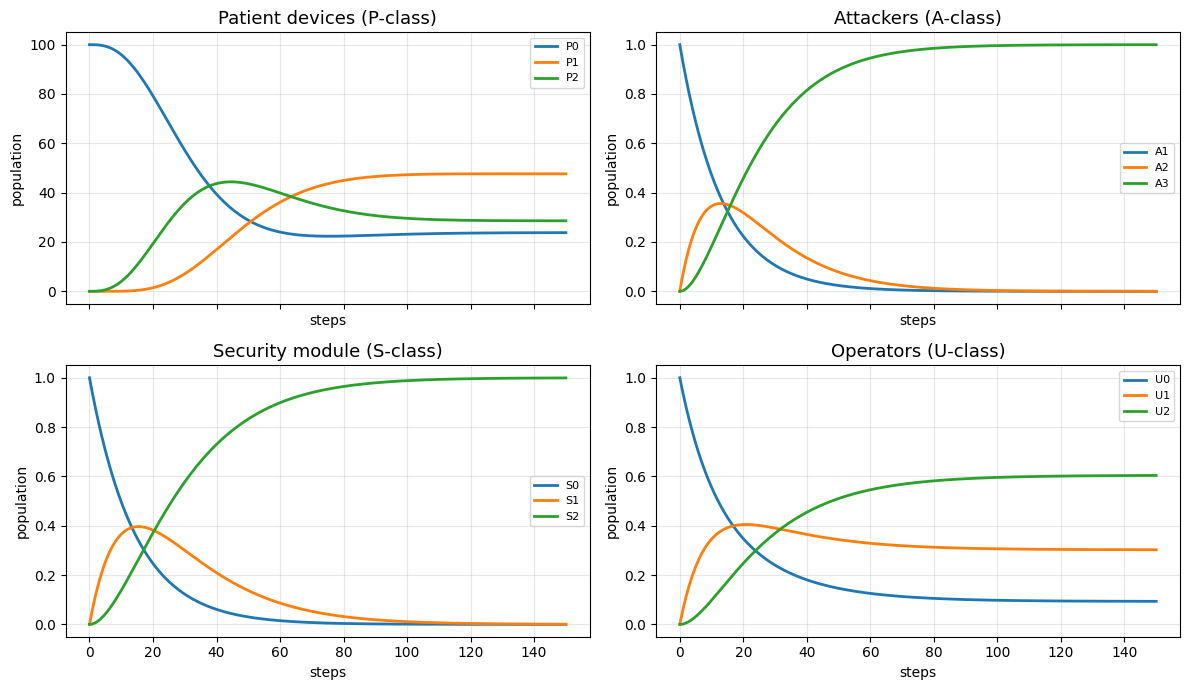

In [1]:


import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Transition probabilities  (Tables 4 & 5)  →  rates λ = p·ν
# ------------------------------------------------------------------
ν = 0.1  # base velocity [transitions/hour]

# Table 4
prob = dict(
    P0_P2 = 0.60, P2_P1 = 0.50, P1_P0 = 0.30,
    A1_A2 = 0.75, A2_A3 = 0.80,
    S0_S1 = 0.70,           # given
    S1_S2 = 0.60,           # **assumed** – not in table, needed in ODEs
)

# Table 5
prob.update(
    U0_U1 = 0.65, U1_U2 = 0.50, U2_U1 = 0.25, U1_U0 = 0.20,
)

λ = {k: v*ν for k, v in prob.items()}

# ------------------------------------------------------------------
# 2. State index helper
# ------------------------------------------------------------------
idx = {s: i for i, s in enumerate(
    ['P0','P1','P2', 'A1','A2','A3', 'S0','S1','S2', 'U0','U1','U2']
)}
N = len(idx)

# convenient slices for plotting
slc = dict(P=slice(0,3), A=slice(3,6), S=slice(6,9), U=slice(9,12))

labels = list(idx.keys())

# ------------------------------------------------------------------
# 3. Initial population vector  Π(0)
# ------------------------------------------------------------------
Π0 = np.zeros(N)
Π0[idx['P0']] = 100.    # 100 healthy devices
Π0[idx['A1']] =   1.
Π0[idx['S0']] =   1.
Π0[idx['U0']] =   1.

# ------------------------------------------------------------------
# 4. ODE right-hand side  (directly from paper’s equations)
# ------------------------------------------------------------------
def rhs(t, P):
    d = np.zeros_like(P)

    P0, P1, P2 = (P[idx[k]] for k in ('P0','P1','P2'))
    A1, A2, A3 = (P[idx[k]] for k in ('A1','A2','A3'))
    S0, S1, S2 = (P[idx[k]] for k in ('S0','S1','S2'))
    U0, U1, U2 = (P[idx[k]] for k in ('U0','U1','U2'))

    # ---- patient-device chain -----------------------------------
    d[idx['P0']] = -λ['P0_P2']*A3*P0 + λ['P1_P0']*P1
    d[idx['P2']] =  λ['P0_P2']*A3*P0 - λ['P2_P1']*S2*P2
    d[idx['P1']] =  λ['P2_P1']*S2*P2 - λ['P1_P0']*P1

    # ---- attacker chain -----------------------------------------
    d[idx['A1']] = -λ['A1_A2']*A1
    d[idx['A2']] =  λ['A1_A2']*A1 - λ['A2_A3']*A2
    d[idx['A3']] =  λ['A2_A3']*A2

    # ---- security module ----------------------------------------
    d[idx['S0']] = -λ['S0_S1']*S0
    d[idx['S1']] =  λ['S0_S1']*S0 - λ['S1_S2']*S1
    d[idx['S2']] =  λ['S1_S2']*S1

    # ---- operator load ------------------------------------------
    d[idx['U0']] = -λ['U0_U1']*U0 + λ['U1_U0']*U1
    d[idx['U1']] =  λ['U0_U1']*U0 - (λ['U1_U2']+λ['U1_U0'])*U1 + λ['U2_U1']*U2
    d[idx['U2']] =  λ['U1_U2']*U1 - λ['U2_U1']*U2

    return d

# ------------------------------------------------------------------
# 5. Integration settings
# ------------------------------------------------------------------
t_end  = 150     # hours
t_grid = np.linspace(0, t_end, 301)

sol = solve_ivp(rhs, (0, t_end), Π0, t_eval=t_grid, rtol=1e-8, atol=1e-10)

# ------------------------------------------------------------------
# 6. Plot helper
# ------------------------------------------------------------------
def subplot(ax, sl, title):
    ax.plot(sol.t, sol.y[sl].T, lw=2)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('steps'); ax.set_ylabel('population')
    ax.grid(alpha=.3); ax.legend([labels[i] for i in range(*sl.indices(N))],
                                 fontsize=8, loc='best')

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,7), sharex=True)

subplot(ax1, slc['P'], 'Patient devices (P-class)')
subplot(ax2, slc['A'], 'Attackers (A-class)')
subplot(ax3, slc['S'], 'Security module (S-class)')
subplot(ax4, slc['U'], 'Operators (U-class)')
plt.savefig("./plots/mam_onepanel.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()
